# 第8章 数据规整：聚合、合并和重塑

在许多__应用__中，__数据__可能__分散在 许多文件或数据库__中，__存储__的__形式__也不利于__分析__。本章关注可以__聚合、合并、重塑 数据__的__方法__。

首先，会介绍__pandas__的__层次化索引__，它广泛用于__以上操作__。然后，__深入介绍__一些__特殊的 数据操作__。在__第14章__，你可以看到__这些工具__的__多种应用__。

# 1.层次化索引

__层次化索引__(hierarchical indexing)是__pandas__的一项__重要功能__，它使你能在__一个轴__上拥有__多个(两个以上)索引级别__。抽象点说，它使你能以__低维度形式__处理__高维度数据__。

### Series

我们先来看一个简单的例子：创建一个__Series__，并用一个由__列表或数组__组成的__列表__作为__索引__：

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.Series(np.random.randn(9),
                index=[['a','a','a','b','b','c','c','d','d'],[1,2,3,1,3,1,2,2,3]])

data

a  1    0.731105
   2   -0.132046
   3    0.512378
b  1    0.451426
   3   -0.321880
c  1    0.121936
   2    0.282937
d  2    0.056416
   3   -0.517917
dtype: float64

- 看到的__结果__是经过__美化__的带有__MultiIndex索引__的__Series 的格式__。索引之间的__“间隔”__表示__“直接使用 上面的 标签”__：

In [4]:
data.index

MultiIndex(levels=[['a', 'b', 'c', 'd'], [1, 2, 3]],
           labels=[[0, 0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 0, 2, 0, 1, 1, 2]])

- 对于一个__层次化索引的 对象__，可以使用所谓的__部分索引__，使用它选取__数据子集__的操作__更简单__：

In [5]:
data['b']

1    0.451426
3   -0.321880
dtype: float64

In [6]:
data['b':'c']

b  1    0.451426
   3   -0.321880
c  1    0.121936
   2    0.282937
dtype: float64

In [7]:
data.loc[['b','d']]

b  1    0.451426
   3   -0.321880
d  2    0.056416
   3   -0.517917
dtype: float64

- 有时甚至还可以在__“内层”__中进行选取：

In [8]:
data.loc[:,2]

a   -0.132046
c    0.282937
d    0.056416
dtype: float64

__层次化索引__在__数据重塑__和__基于分组的 操作__(如__透视表__生成)中扮演着__重要__的角色。

- 例如，可以通过__unstack方法__将这段数据__重新安排__到一个__DataFrame__中：

In [9]:
data.unstack()

,1,2,3
a,0.731105,-0.132046,0.512378
b,0.451426,NaN,-0.321880
c,0.121936,0.282937,NaN
d,NaN,0.056416,-0.517917


- unstack的__逆运算__是__stack__：

In [10]:
data.unstack().stack()

a  1    0.731105
   2   -0.132046
   3    0.512378
b  1    0.451426
   3   -0.321880
c  1    0.121936
   2    0.282937
d  2    0.056416
   3   -0.517917
dtype: float64

__stack和unstack__将在本章后面__详细讲解__。

### DataFrame
- 对于一个__DataFrame__，__每条轴__都可以有__分层索引__：

In [11]:
frame = pd.DataFrame(np.arange(12).reshape((4,3)),
                    index=[['a','a','b','b'],[1,2,1,2]],
                    columns=[['Ohio','Ohio','Colorrado'],['Green','Red','Green']])

frame

Ohio     Colorrado
    Green Red     Green
a 1     0   1         2
  2     3   4         5
b 1     6   7         8
  2     9  10        11

- __各层__都可以有__名字__(可以是__字符串__，也可以是__别的Python对象__)。如果__指定了 名称__，它们就会__显示__在控制台输出中：

In [12]:
frame.index.names = ['key1', 'key2']
frame.columns.names = ['state', 'color']

In [13]:
frame

state      Ohio     Colorrado
color     Green Red     Green
key1 key2                    
a    1        0   1         2
     2        3   4         5
b    1        6   7         8
     2        9  10        11

注意：小心区分__索引名__state、color与__行标签__。

- 有了__部分列 索引__，因此可以轻松选取__列分组__：

In [14]:
frame['Ohio']

color      Green  Red
key1 key2            
a    1         0    1
     2         3    4
b    1         6    7
     2         9   10

- 可以__单独创建 MultiIndex__然后__复用__。

上面那个__DataFrame__中的(带有__分级名称__)__列__可以这样创建：

In [15]:
# 创建方式一：特定结构
m_columns = pd.MultiIndex.from_arrays([['Ohio','Ohio','Calorado'],['Green','Red','Green']],
                       names=['state', 'color'])

m_columns

MultiIndex(levels=[['Calorado', 'Ohio'], ['Green', 'Red']],
           labels=[[1, 1, 0], [0, 1, 0]],
           names=['state', 'color'])

In [16]:
m_index = pd.MultiIndex.from_arrays([['a','a','b','b'],[1,2,1,2]],
                                   names=['key1','key2'])
m_index

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names=['key1', 'key2'])

In [17]:
# 复用
frame2 = pd.DataFrame(np.arange(12).reshape((4,3)),
                      index=m_index,
                      columns=m_columns)

frame2

state      Ohio     Calorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

## 1.1 重排与分级排序

有时，你需要__重新调整 某条轴__上__各级别__的__顺序__，或根据__指定级别__上的**值**对数据进行__排序__。

- swaplevel接受__两个//级别编号或名称__，并返回一个__互换了级别__的__新对象__(但__数据不会发生变化__)：

In [18]:
frame.swaplevel('key1','key2')

state      Ohio     Colorrado
color     Green Red     Green
key2 key1                    
1    a        0   1         2
2    a        3   4         5
1    b        6   7         8
2    b        9  10        11

In [19]:
frame.swaplevel('state','color',axis=1)

color     Green  Red     Green
state      Ohio Ohio Colorrado
key1 key2                     
a    1        0    1         2
     2        3    4         5
b    1        6    7         8
     2        9   10        11

- __sort_index__则根据__单个级别__中的**值**对数据进行__排序__。
- __交换级别__时，常常也会用到__sort_index__，这样__最终结果__就是按照__指定级别__进行__字典排序__了：

In [20]:
frame.sort_index(level=1)

state      Ohio     Colorrado
color     Green Red     Green
key1 key2                    
a    1        0   1         2
b    1        6   7         8
a    2        3   4         5
b    2        9  10        11

In [21]:
frame.swaplevel(0, 1).sort_index(level=1)

state      Ohio     Colorrado
color     Green Red     Green
key2 key1                    
1    a        0   1         2
2    a        3   4         5
1    b        6   7         8
2    b        9  10        11

## 1.2 根据级别汇总统计

- 许多对__DataFrame和Series__的__描述和汇总统计__都有一个__level选项__，它用于指定在__某条轴上 求和的 级别__。

再以上面那个__DataFrame__为例，我们可以根据__行或列__上的__级别__来进行__求和__：

In [22]:
frame.sum(level='key2')

state  Ohio     Colorrado
color Green Red     Green
key2                     
1         6   8        10
2        12  14        16

In [23]:
frame.sum(level='color', axis=1)

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

这其实是利用了__pandas__的__groupby功能__，本书稍后将对其进行__详细讲解__。

## 1.3 使用DataFrame的列进行行索引

- 人们经常想要将__DataFrame__的__一个或多个列__当做__行索引__来用，
- 或者可能希望将__行索引__变成__DataFrame的列__。

以下面这个__DataFrame__为例：

In [24]:
frame = pd.DataFrame({'a':range(7), 'b':range(7, 0, -1), 'c':['one','one','one','two','two','two','two'], 'd':[0,1,2,0,1,2,3]})

frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


- __DataFrame__的__set_index函数__会将__其一个或多个列__转换为__行索引__，并创建一个__新的DataFrame__：

In [25]:
frame2 = frame.set_index(['c', 'd'])

frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

__默认情况__下，__那些列__会从DataFrame中__移除__，但也可以将其__保留__下来：

In [26]:
frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

- __reset_index__的功能跟__set_index__刚好__相反__，__层次化索引的 级别__会被__转移到 列__里面：

In [27]:
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


# 2.合并数据集

__pandas对象__中的__数据__可以通过一些方式进行__合并__： 

- __pandas.merge__可根据__一个或多个键__将__不同DataFrame中的 行__连接起来。__SQL或其他关系型数据库__的用户对此应该会比较熟悉，因为它实现的就是__数据库的join 操作__。
- __pandas.concat__可以沿着__一条轴__将__多个对象 堆叠__到一起。 
- __实例方法combine_first__可以将__重复数据 编接__在一起，用__一个对象中的 值__填充__另一个对象中的 缺失值__。

将分别对它们进行__讲解__，并给出一些__例子__。本书剩余部分的__示例__中将__经常用到__它们。

## 2.1 数据库风格的DataFrame合并(根据列索引(列名)，将行连接起来)

数据集的__合并(merge)或连接(join)__运算是通过__一个或多个键__将**行**链接起来的。这些运算是__关系型数据库__(基于SQL)的__核心__。
- __pandas的 merge函数__是对数据应用__这些算法__的__主要切入点__。

### 2.1.1 多对一的合并
以一个简单的例子开始：

In [28]:
df1 = pd.DataFrame({'key':['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                   'data1':range(7)})

df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [29]:
df2 = pd.DataFrame({'key':['a', 'b', 'd'],
                   'data2':range(3)})

df2

,key,data2
0,a,0
1,b,1
2,d,2


这是一种__多对一的 合并__。df1中的数据有__多个__被标记为a和b的行，而df2中__key列__的__每个值__则仅对应__一行__。

- 对这些对象调用__merge__即可得到：

In [30]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


- 注意，并__没有指明__要用__哪个列__进行__连接__。如果__没有指定__，__merge__就会将__重叠列的列名__当做__键__。不过，最好**明确指定**一下：

In [31]:
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


- 如果__两个对象__的__列名 不同__，也可以__分别__进行__指定__：

In [32]:
df3 = pd.DataFrame({'lkey':['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                   'data1':range(7)})

df3

,lkey,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [33]:
df4 = pd.DataFrame({'rkey':['a', 'b', 'd'],
                   'data2':range(3)})

df4

,rkey,data2
0,a,0
1,b,1
2,d,2


In [34]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


可能你已经注意到了，__结果__里面__c和d__以及__与之相关的 数据__消失了。
- __默认__情况下，__merge__做的是__“内连接”__；结果中的__键 是交集__。其他方式还有__"left"、"right"以及"outer"__。

- __外连接__求取的是__键 的并集__，__组合了 左连接和右连接__的效果：

In [35]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


__表8-1__对这些__选项__进行了__总结__。
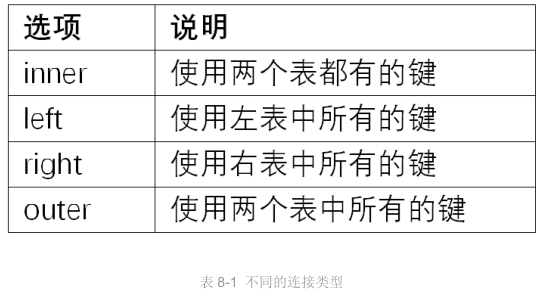

### 2.1.2 多对多的合并

__多对多的 合并__有些不直观。看下面的例子：

In [36]:
df1 = pd.DataFrame({'key':['b', 'b', 'a', 'c', 'a', 'b'],
                   'data1':range(6)})
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [37]:
df2 = pd.DataFrame({'key':['a', 'b', 'a', 'b', 'd'],
                   'data2':range(5)})
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [38]:
pd.merge(df1, df2, on='key', how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


- __多对多连接__产生的是__行的 笛卡尔积__。

由于__左边__的DataFrame有__3个"b"行__，__右边__的有__2个__，所以__最终结果__中就有__6 个"b"行__。__连接方式__只影响出现在__结果__中的__不同的 键的值__：

总结：
- __连接方式__：决定出现在__结果__中的__不同的 键的值__，内、左、右、外。
- __多对多连接__：产生__行的 笛卡儿积__。多对一也可以看作笛卡儿积。

In [39]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


- 要根据__多个键__进行__合并__，传入一个由__列名__组成的__列表__即可：

In [40]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'], 
                     'key2': ['one', 'two', 'one'], 
                     'lval': [1, 2, 3]})

left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [41]:
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'], 
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [42]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


__结果__中会出现__哪些键组合__取决于所选的__合并方式__，你可以这样来理解：__多个键__形成__一系列元组__，并将其当做__单个连接键__(当然，__实际上并不是__这么回事)。

- 注意：在进行__列－列连接__时，__DataFrame对象__中的__索引__会被__丢弃__。

- 对于__合并运算__需要考虑的__最后一个问题__是对__重复列名__的处理。

虽然你可以__手工处理 列名重叠__的问题(查看前面介绍的__重命名轴标签__)，但__merge__有一个更实用的__suffixes选项__，用于__指定__附加到__左右两个DataFrame对象__的__重叠列名__上的__字符串__：

In [43]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [44]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


__merge__的__参数__请参见表 8-2。使用__DataFrame的 行索引 合并__是__下一节__的主题。


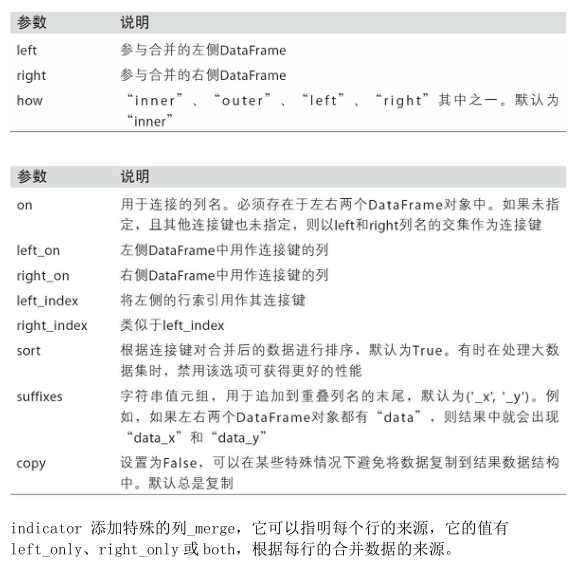

## 2.2 索引上的合并

### 2.2.1 pd.merge()
有时候，__DataFrame__中的__连接键__位于__其索引__中。

- 在这种情况下，你可以传入__left_index=True或right_index=True(或两个都传)__以说明__索引__应该被用作__连接键__：

In [45]:
left1 = pd.DataFrame({'key':['a', 'b', 'a', 'a', 'b', 'c'],
                     'value':range(6)})
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [46]:
right1 = pd.DataFrame({'group_val':[3.5, 7]},
                     index=['a', 'b'])
right1

,group_val
a,3.5
b,7.0


In [47]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


由于__默认__的__merge方法__是求取__连接键的 交集__，因此你可以通过__外连接__的方式得到它们的__并集__：

In [48]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


- 对于__层次化索引__的数据，事情就__有点复杂__了，因为__(这里)索引的 合并 默认__是__多键合并__：

In [49]:
lefth = pd.DataFrame({'key1':['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
                     'key2':[2000, 2001, 2002, 2001, 2002],
                     'data':np.arange(5.)})

lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [50]:
righth = pd.DataFrame(np.arange(12).reshape((6,2)),
                     index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'],[2001, 2000, 2000, 2000, 2001, 2002]],
                     columns=['event1', 'event2'])

righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

- 这种情况下，你必须以__列表__的形式__指明__用作__合并键的 多个列__(注意用__how='outer'__对__重复索引值__的__处理__)：

In [51]:
pd.merge(lefth, righth, left_on=['key1','key2'], right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [52]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


- 同时使用__合并双方的 索引__也没问题：

In [53]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                    index=['a', 'c', 'e'],
                    columns=['Ohio', 'Nevada'])
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [54]:
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                     index=['b', 'c', 'd', 'e'],
                     columns=['Missouri', 'Alabama'])
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [55]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


### 2.2.2 join()

- __DataFrame__还有一个__便捷的 join实例方法__，它能更为方便地实现__按索引 合并__。
- 它还可用于合并__多个__带有__相同或相似索引__的__DataFrame对象__，但要求__没有重叠的列__。

在上面那个例子中，我们可以编写：

In [56]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


因为一些__历史版本__的__遗留原因__，__DataFrame__的__join方法 默认__使用的是__左连接__，__保留 左边表__的__行索引__。

- 它__还支持__在__调用的//DataFrame的列__上，__连接__， __传递的//DataFrame的索引__：

In part for legacy reasons (i.e., much earlier versions of pandas), DataFrame’s join method performs a left join on the join keys, exactly preserving the left frame’s row index. It also supports joining the index of the passed DataFrame on one of the columns of the calling DataFrame:

In [57]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [58]:
right1

,group_val
a,3.5
b,7.0


In [59]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


- 最后，对于__简单的//索引合并__，你还可以向__join__传入__一组DataFrame__，下一节会介绍__更为通用__的__concat函数__，也能实现__此功能__：

In [60]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                      index=['a', 'c', 'e', 'f'],
                      columns=['New York', 'Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [61]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [62]:
left2.join([right2, another], how='outer')

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6369: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  verify_integrity=True)


,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
b,NaN,NaN,7.0,8.0,NaN,NaN
c,3.0,4.0,9.0,10.0,9.0,10.0
d,NaN,NaN,11.0,12.0,NaN,NaN
e,5.0,6.0,13.0,14.0,11.0,12.0
f,NaN,NaN,NaN,NaN,16.0,17.0


## 2.3 轴向连接

另一种__数据合并运算__也被称作__连接(concatenation)、绑定(binding)或堆叠(stacking)__。

- __NumPy__的__concatenation函数__可以用__NumPy数组__来做：

In [63]:
arr = np.arange(12).reshape((3, 4))

arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [64]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

对于__pandas对象__(如__Series和DataFrame__)，__带有标签的 轴__使你能够进一步__推广 数组 的连接运算__。__具体__点说，你还需要__考虑__以下这些东西：
- 如果__对象__在__其它轴__上的__索引不同__，我们应该__合并 这些轴的 不同元素__还是__只使用 交集__？
- __连接的 数据集__是否需要在__结果对象__中__可识别__？
- __连接轴__中__保存的数据__是否需要__保留__？许多情况下，__DataFrame默认的 整数标签__最好__在连接时 删掉__。

- __pandas__的__concat函数__提供了一种能够__解决这些问题__的__可靠方式__。

### 2.3.1 Series
将给出一些例子来讲解其__使用方式__。假设有三个__没有重叠索引__的__Series__：

In [65]:
s1 = pd.Series([0, 1], index=['a', 'b'])
s1

a    0
b    1
dtype: int64

In [66]:
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])
s2

c    2
d    3
e    4
dtype: int64

In [67]:
s3 = pd.Series([5, 6], index=['f', 'g'])
s3

f    5
g    6
dtype: int64

- 对__这些对象__调用__concat__可以将__值和索引 粘合__在一起：

In [68]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

- __默认__情况下，__concat__是在__axis=0__上工作的，最终产生一个__新的Series__。
- 如果传入__axis=1__，则__结果__就会变成一个__DataFrame__(__axis=1是 列__)：

In [69]:
pd.concat([s1, s2, s3], axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


这种情况下，__另外的轴上 没有重叠__，从__索引__的__有序并集__(__外连接__)上就可以看出来。
- 传入__join='inner'__即可得到它们的__交集__：

In [71]:
s4 = pd.concat([s1, s3])
s4

a    0
b    1
f    5
g    6
dtype: int64

In [78]:
pd.concat([s1, s4], axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [79]:
pd.concat([s1, s4], axis=1, join="inner")

,0,1
a,0,0
b,1,1


在这个例子中，__f和g标签 消失了__，是因为使用的是__join='inner'选项__。

- 你可以通过__join_axes__指定要在__其它轴__上使用的__索引__：

In [84]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,1.0
e,NaN,NaN


不过有个__问题__，__参与连接的 片段__在__结果__中__区分不开__。假设你想要在__连接轴__上创建一个__层次化索引__。
- 使用__keys参数__即可达到这个__目的__：

In [87]:
result = pd.concat([s1, s1, s3], keys=['one', 'two', 'three'])

result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [88]:
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


如果沿着__axis=1__对__Series进行合并__，则__keys__就会成为__DataFrame的 列头__：

In [89]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


### 2.3.2 DataFrame

__同样的逻辑__也适用于__DataFrame对象__：

In [90]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2),
                  index=['a', 'b', 'c'],
                  columns=['one', 'two'])

df1

,one,two
a,0,1
b,2,3
c,4,5


In [92]:
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2),
                  index=['a', 'c'],
                  columns=['three', 'four'])
df2

,three,four
a,5,6
c,7,8


In [93]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

- 如果传入的__不是列表__而是一个__字典__，则__字典的键__就会被当做__keys选项的 值__：

In [94]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

- 此外还有__两个__用于管理__层次化索引 创建方式 的参数__(参见表8-3)。
举个例子，我们可以用__names参数 命名 创建的轴级别__：

In [95]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'], names=['upper', 'lower'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

- 最后一个关于__DataFrame__的__问题__是，__DataFrame的 行索引 不包含 任何相关数据__：

In [96]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df1

,a,b,c,d
0,0.643318,-1.556564,0.369107,-0.735079
1,0.542879,-1.230283,-1.321332,2.215816
2,-0.382351,1.215169,1.187998,1.264100


In [98]:
df2 = pd.DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
df2

,b,d,a
0,-0.164037,0.334175,-1.181396
1,1.133562,0.906332,0.322425


- 在这种情况下，传入__ignore_index=True__即可：

In [99]:
pd.concat([df1, df2], ignore_index=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,a,b,c,d
0,0.643318,-1.556564,0.369107,-0.735079
1,0.542879,-1.230283,-1.321332,2.215816
2,-0.382351,1.215169,1.187998,1.264100
3,-1.181396,-0.164037,NaN,0.334175
4,0.322425,1.133562,NaN,0.906332


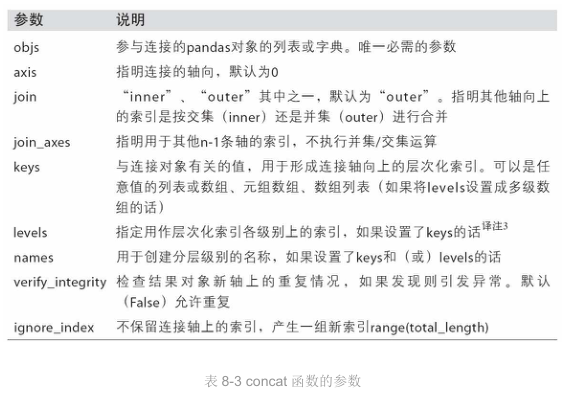

## 2.4 合并重叠数据

还有一种__数据组合问题__不能用__简单的合并(merge)或连接(concatenation)运算__来处理。比如说，你可能有__索引 全部或部分 重叠__的__两个数据集__。

- 举个有__启发性__的例子，我们使用__NumPy__的__where函数__，它表示一种__等价于 面向数组的if-else__：

In [107]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
             index=['f', 'e', 'd', 'c', 'b', 'a'])
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [109]:
b = pd.Series(np.arange(len(a), dtype=np.float64),
              index=['f', 'e', 'd', 'c', 'b', 'a'])
b[-1] = np.nan

b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [110]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, nan])

- __Series__有一个__combine_first方法__，实现的也是__一样的功能__，还带有__pandas的数据对齐__：

In [111]:
b[:-2]

f    0.0
e    1.0
d    2.0
c    3.0
dtype: float64

In [112]:
a[2:]

d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [113]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

- 对于__DataFrame__，__combine_first__自然也会在__列__上做**同样的事情**，因此你可以将其**看做**：用**传递对象中的 数据**为**调用对象 的缺失数据 “打补丁”**：

In [114]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
                   'b': [np.nan, 2., np.nan, 6.],
                   'c': range(2, 18, 4)})

df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [115]:
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.],
                   'b': [np.nan, 3., 4., 6., 8.]})
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [116]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


# 3.重塑和轴向旋转

有许多用于__重新排列 表格型数据__的__基础运算__。这些__函数__也称作__重塑(reshape)或轴向旋转(pivot)运算__。

## 3.1 重塑层次化索引

__层次化索引__为__DataFrame数据的 重排任务__提供了一种具有__良好一致性__的__方式__。
__主要功能__有二：
- stack：将数据的**列**“旋转”为__行__。
- unstack：将数据的**行**“旋转”为__列__。

将通过一系列的范例来讲解__这些操作__。接下来看一个简单的__DataFrame__，其中的__行列索引__均为__字符串数组__：

In [117]:
data = pd.DataFrame(np.arange(6).reshape((2, 3)),
                   index=pd.Index(['Ohio', 'Colorado'], name='state'),
                   columns=pd.Index(['one', 'two', 'three'], name='number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


- 对该数据使用__stack方法__即可将__列 转换为 行__，得到一个**Series**：

In [119]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

- 对于一个__层次化索引的 Series__，你可以用__unstack__将其__重排__为一个__DataFrame__：

In [120]:
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


- __默认__情况下，__unstack__操作的是__最内层___(__stack__也是如此)。
- 传入__分层级别的 编号或名称__即可对__其它级别__进行__unstack操作__：

In [121]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [122]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


- 如果不是__所有的级别值__都能在__各分组__中__找到__的话，则__unstack操作__可能会引入__缺失数据__：

In [123]:
s1 = pd.Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])
s1

a    0
b    1
c    2
d    3
dtype: int64

In [124]:
s2 = pd.Series([4, 5, 6], index=['c', 'd', 'e'])
s2

c    4
d    5
e    6
dtype: int64

In [125]:
data2 = pd.concat([s1, s2], keys=['one', 'two'])

data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [126]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


- __stack 默认__会__滤除 缺失数据__，因此__该运算__是__可逆__的：

In [127]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [128]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

在对__DataFrame__进行__unstack操作__时，作为__旋转轴的 级别__将会成为__结果中的 最低级别__：

In [129]:
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

In [132]:
df = pd.DataFrame({'left': result, 'right': result + 5},
                 columns=pd.Index(['left', 'right'], name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [133]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

- 当调用__stack__，我们可以__指明 轴的名字__：

In [134]:
df.unstack('state').stack('side')

state         Colorado  Ohio
number side                 
one    left          3     0
       right         8     5
two    left          4     1
       right         9     6
three  left          5     2
       right        10     7

## 3.2 将“长格式”旋转为“宽格式”

__多个时间序列数据__通常是以所谓的__“长格式”(long)或“堆叠格式”(stacked)__存储在**数据库和CSV**中的。

我们先加载一些__示例数据__，做一些__时间序列规整和数据清洗__：

In [168]:
data = pd.read_csv('examples/macrodata.csv')

data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [169]:
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name='date')

periods

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='date', length=203, freq='Q-DEC')

In [170]:
columns = pd.Index(['realgdp', 'infl', 'unemp'], name='item')
columns

Index(['realgdp', 'infl', 'unemp'], dtype='object', name='item')

In [171]:
data = data.reindex(columns=columns)

data.head()

item,realgdp,infl,unemp
0,2710.349,0.00,5.8
1,2778.801,2.34,5.1
2,2775.488,2.74,5.3
3,2785.204,0.27,5.6
4,2847.699,2.31,5.2


In [172]:
data.index = periods.to_timestamp('D', 'end')

data.head()

item,realgdp,infl,unemp
date,,,
1959-03-31,2710.349,0.00,5.8
1959-06-30,2778.801,2.34,5.1
1959-09-30,2775.488,2.74,5.3
1959-12-31,2785.204,0.27,5.6
1960-03-31,2847.699,2.31,5.2


In [173]:
ldata = data.stack().reset_index().rename(columns={0: 'value'})

ldata.head()

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340


这就是__多个时间序列__(或者__其它__带有__两个或多个键__的__可观察数据__，这里，我们的**键**是__date和item__)的__长格式__。

表中的__每行__代表__一次观察__。

__关系型数据库__(如MySQL)中的__数据__经常都是这样__存储__的，因为__固定架构__(即__列名和数据类型__)有一个__好处__：随着表中__数据__的__添加__，__item列__中的__值的 种类 能够增加__。

在前面的例子中，__date和item__通常就是__主键__(用__关系型数据库__的说法)，不仅提供了__关系完整性__，而且提供了__更为简单的 查询支持__。

__有的情况__下，使用这样的数据会__很麻烦__，你可能会__更喜欢 DataFrame__，__不同的 item值__分别形成__一列__，__date列__中的__时间戳__则用作__索引__。

- __DataFrame__的__pivot方法__完全可以__实现__这个__转换__：

In [174]:
pivoted = ldata.pivot('date', 'item', 'value')

pivoted.head()

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


- __前两个__传递的__值__分别用作__行和列索引__，最后一个__可选值__则是用于__填充 DataFrame 的数据列__。
- 假设有__两个 需要 同时 重塑__的__数据列__：

In [175]:
ldata['value2'] = np.random.randn(len(ldata))

ldata[:10]

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,-0.588621
1,1959-03-31,infl,0.000,-0.912711
2,1959-03-31,unemp,5.800,-0.225584
3,1959-06-30,realgdp,2778.801,2.746505
4,1959-06-30,infl,2.340,-1.197044
5,1959-06-30,unemp,5.100,-0.739005
6,1959-09-30,realgdp,2775.488,-0.575135
7,1959-09-30,infl,2.740,0.731908
8,1959-09-30,unemp,5.300,-2.406166
9,1959-12-31,realgdp,2785.204,-1.271033


- 如果__忽略 最后一个参数__，得到的__DataFrame__就会带有__层次化的 列__：

In [176]:
pivoted = ldata.pivot('date', 'item')

pivoted[:5]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.912711 -0.588621 -0.225584
1959-06-30  2.34  2778.801   5.1 -1.197044  2.746505 -0.739005
1959-09-30  2.74  2775.488   5.3  0.731908 -0.575135 -2.406166
1959-12-31  0.27  2785.204   5.6 -0.670793 -1.271033 -0.758198
1960-03-31  2.31  2847.699   5.2  1.790072  0.820706  1.860557

In [177]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


- 注意，__pivot__其实就是用__set_index 创建 层次化索引__，再用__unstack 重塑__：

In [178]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')

unstacked[:7]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.912711 -0.588621 -0.225584
1959-06-30  2.34  2778.801   5.1 -1.197044  2.746505 -0.739005
1959-09-30  2.74  2775.488   5.3  0.731908 -0.575135 -2.406166
1959-12-31  0.27  2785.204   5.6 -0.670793 -1.271033 -0.758198
1960-03-31  2.31  2847.699   5.2  1.790072  0.820706  1.860557
1960-06-30  0.14  2834.390   5.2  0.639557  0.433176 -2.557773
1960-09-30  2.70  2839.022   5.6  0.532738 -0.529774  0.653118

## 3.3 将“宽格式”旋转为“长格式”

- __旋转DataFrame__的__逆运算__是__pandas.melt__。

它不是将__一列__转换到__多个列的 新的DataFrame__，而是__合并 多个列 成为一个__，产生一个__比输入长的 DataFrame__。看一个例子：

In [179]:
df = pd.DataFrame({'key': ['foo', 'bar', 'baz'],
                  'A': [1, 2, 3],
                  'B': [4, 5, 6],
                  'C': [7, 8, 9]})
df

,key,A,B,C
0,foo,1,4,7
1,bar,2,5,8
2,baz,3,6,9


__key列__可能是__分组指标__，__其它的列__是__数据值__。
- 当使用__pandas.melt__，我们必须__指明 哪些列 是分组指标__。下面使用__key__作为__唯一的 分组指标__：

In [180]:
melted = pd.melt(df, ['key'])

melted

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6
6,foo,C,7
7,bar,C,8
8,baz,C,9


- 使用__pivot__，可以__重塑__回__原来的样子__：

In [182]:
reshaped = melted.pivot('key', 'variable', 'value')

reshaped

variable,A,B,C
key,,,
bar,2,5,8
baz,3,6,9
foo,1,4,7


- 因为__pivot 的结果__从__列 创建了一个 索引__，用作__行标签__，我们可以使用**reset_index**将数据 __移回列__：

In [183]:
reshaped.reset_index()

variable,key,A,B,C
0,bar,2,5,8
1,baz,3,6,9
2,foo,1,4,7


- 你还可以指定__列的子集__，作为__值的列__：

In [184]:
pd.melt(df, id_vars=['key'], value_vars=['A', 'B'])

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6


- __pandas.melt__也可以__不用 分组指标__：

In [185]:
pd.melt(df, value_vars=['A', 'B', 'C'])

,variable,value
0,A,1
1,A,2
2,A,3
3,B,4
4,B,5
5,B,6
6,C,7
7,C,8
8,C,9


In [186]:
pd.melt(df, value_vars=['key', 'A', 'B'])

,variable,value
0,key,foo
1,key,bar
2,key,baz
3,A,1
4,A,2
5,A,3
6,B,4
7,B,5
8,B,6


# 4.总结

现在你已经掌握了__pandas 数据导入、清洗、重塑__，我们可以进一步学习__matplotlib数据可视化__。我们在稍后会回到__pandas__，学习__更高级的 分析__。